In [1]:
!pip install -q kagglehub scikit-learn pandas matplotlib tensorflow

In [2]:
import kagglehub

# Download
path = kagglehub.dataset_download("greatgamedota/dfdc-part-34")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dfdc-part-34


In [3]:
import pandas as pd
import os

metadata = pd.read_csv(f"{path}/images/metadata34.csv")

# .mp4 uzantısını kaldır
metadata["filename"] = metadata["filename"].str.replace(".mp4", "", regex=False)
metadata["original"] = metadata["original"].str.replace(".mp4", "", regex=False)

print(metadata.head())

     filename label  split    original
0  zhmjtavtpn  FAKE  train  ejnrxekehh
1  dazellwbsl  FAKE  train  xuxkfhqjiu
2  elwdztqnot  FAKE  train  xlyxbyhjsq
3  fiedwlcwyn  FAKE  train  skhnvzyukn
4  svbcewtjvh  FAKE  train  arrpqqfiah


In [4]:
from glob import glob

def get_image_paths(base_path, filename):
    folder = os.path.join(base_path, "images", filename)
    image_paths = sorted(glob(f"{folder}/*.jpg"), key=lambda x: int(os.path.basename(x).split(".")[0]))
    return image_paths

# Örnek olarak: bir klasördeki tüm frame'ler:
sample_images = get_image_paths(path, metadata["filename"].iloc[0])
print(sample_images)

['/kaggle/input/dfdc-part-34/images/zhmjtavtpn/0.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/30.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/60.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/90.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/120.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/150.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/180.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/210.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/240.jpg', '/kaggle/input/dfdc-part-34/images/zhmjtavtpn/270.jpg']


In [5]:
from collections import defaultdict

# Her REAL video için FAKE varyantlarını tutan bir dict
real_to_fakes = defaultdict(list)

for _, row in metadata.iterrows():
    if row['label'] == 'FAKE':
        real = row['original']
        fake = row['filename']
        real_to_fakes[real].append(fake)

# Kontrol
for real, fakes in list(real_to_fakes.items())[:5]:
    print(f"REAL: {real} → FAKEs: {fakes}")

REAL: ejnrxekehh → FAKEs: ['zhmjtavtpn', 'fkssfkbrkp', 'zaynuhjaci', 'etewvhbnzs', 'pccwidwbwh', 'awibecpxci', 'xjcoinhsdx']
REAL: xuxkfhqjiu → FAKEs: ['dazellwbsl', 'cwgnnijunv', 'qvedkofrey', 'gjthassixk', 'cbkqrlaiyi', 'ecdgxqhelh', 'bnsyxqrgae', 'jftrbnijmt', 'lavnzallny', 'wqsuimspwa', 'krnhpqtmiu', 'cxkymqpwuq', 'tpcflvfoqo', 'whrykekthg', 'cnrofrairp', 'nngphqdnot', 'vohguniokm', 'vrwpihsuwj', 'cwktquxciy', 'htvpaolyrq', 'sevcmzjyvo']
REAL: xlyxbyhjsq → FAKEs: ['elwdztqnot', 'ebxopxoftt', 'vxucpqtbuf', 'evkevitmfx', 'gahlzfbmst', 'xcrbcszeqb', 'qdpkezyqib', 'yhjlqgldfh', 'hdidvxfppi', 'fjnupufknt', 'jglrfawgpc', 'hqytjkkmus', 'agrqzohqhx', 'aajrzgorsm', 'lyffdrzfmv', 'nutillbije', 'sttoxniflx', 'hhcapkusnr', 'dctbnichwl', 'tgepzyrrkm', 'lkomcvfnsn', 'jytyijewbu']
REAL: skhnvzyukn → FAKEs: ['fiedwlcwyn', 'cazuqtjfrn', 'uagcrisovu', 'pfbicotttj', 'yqcfpwqlsl', 'mlhuxixymc', 'wtfxmkdcgn', 'enpdzuwrqu', 'zjijfdkjxm']
REAL: arrpqqfiah → FAKEs: ['svbcewtjvh', 'olleeauetp', 'jdhxlmqgij

In [6]:
rows = []

for real, fakes in real_to_fakes.items():
    for fake in fakes:
        rows.append({"real": real, "fake": fake})

real_fake_df = pd.DataFrame(rows)
print(real_fake_df.head())

         real        fake
0  ejnrxekehh  zhmjtavtpn
1  ejnrxekehh  fkssfkbrkp
2  ejnrxekehh  zaynuhjaci
3  ejnrxekehh  etewvhbnzs
4  ejnrxekehh  pccwidwbwh


In [7]:
# Tüm REAL dosya isimlerini küme halinde al (sadece label'ı REAL olanlar)
real_filenames = set(metadata[metadata['label'] == 'REAL']['filename'])

missing_originals = []

for _, row in metadata.iterrows():
    if row['label'] == 'FAKE' and row['original'] not in real_filenames:
        missing_originals.append((row['filename'], row['original']))

# Sonuç
if missing_originals:
    print(f"{len(missing_originals)} FAKE dosyasının orijinali eksik:")
    for fake, original in missing_originals[:10]:
        print(f"FAKE: {fake} → MISSING ORIGINAL: {original}")
else:
    print("Tüm FAKE dosyaların orijinalleri metadata içinde mevcut.")

Tüm FAKE dosyaların orijinalleri metadata içinde mevcut.


In [8]:
import pandas as pd
from collections import defaultdict

# REAL → FAKE eşleşmesi sözlüğü
real_to_fakes = defaultdict(list)

for _, row in metadata.iterrows():
    if row['label'] == 'FAKE':
        real = row['original']
        fake = row['filename']
        real_to_fakes[real].append(fake)

# FAKE sayısı DataFrame'i
real_fake_count = pd.DataFrame([
    {"real": real, "num_fakes": len(fakes)}
    for real, fakes in real_to_fakes.items()
])

# FAKE sayısına göre büyükten küçüğe sıralama
real_fake_count = real_fake_count.sort_values(by="num_fakes", ascending=False).reset_index(drop=True)

print(real_fake_count.head(1000))

           real  num_fakes
0    xlyxbyhjsq         22
1    xuxkfhqjiu         21
2    fxyzxptcwb         20
3    iaqtariies         20
4    uopfswyygk         20
..          ...        ...
411  pcbwggbzpc          1
412  pokpzfvuli          1
413  gxhmwktmgg          1
414  cigrglaemt          1
415  eirrhmppfo          1

[416 rows x 2 columns]


In [9]:
# preprocessing aşaması

import random
from tqdm import tqdm

frame_numbers = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270]
pair_rows = []
unused_fake_frames = []

# her real için eşleştiği fake klasörleri tut
for real, fakes in tqdm(real_to_fakes.items()):
    available_fakes = fakes.copy()
    used_fakes = set()

    for frame in frame_numbers:
        if len(available_fakes) == 0:
            # havuz boşsa resetle
            available_fakes = list(set(fakes) - used_fakes)
            used_fakes = set()

        if len(available_fakes) == 0:
            # hala boşsa, demek ki fakes çok azdı
            continue

        # random seç, seçileni kaldır ve işaretle
        selected_fake = random.choice(available_fakes)
        available_fakes.remove(selected_fake)
        used_fakes.add(selected_fake)

        pair_rows.append({
            "real_video": real,
            "real_frame": f"{frame}.jpg",
            "fake_video": selected_fake,
            "fake_frame": f"{frame}.jpg"
        })

# eşleşme tablosunu DataFrame'e dök
paired_df = pd.DataFrame(pair_rows)

# şimdi eşleşmeyen dataframeler
all_fake_frames = set()
used_fake_frames = set()

for fake_list in real_to_fakes.values():
    for fake in fake_list:
        for frame in frame_numbers:
            all_fake_frames.add((fake, f"{frame}.jpg"))

for _, row in paired_df.iterrows():
    used_fake_frames.add((row['fake_video'], row['fake_frame']))

unused = all_fake_frames - used_fake_frames

unused_fake_frames_df = pd.DataFrame(list(unused), columns=["fake_video", "fake_frame"])

# Sonuçlar:
print("Eşleşmiş frame çifti sayısı:", len(paired_df))
print("Hiç kullanılmamış fake frame sayısı:", len(unused_fake_frames_df))

100%|██████████| 416/416 [00:00<00:00, 64167.05it/s]

Eşleşmiş frame çifti sayısı: 3392
Hiç kullanılmamış fake frame sayısı: 19028


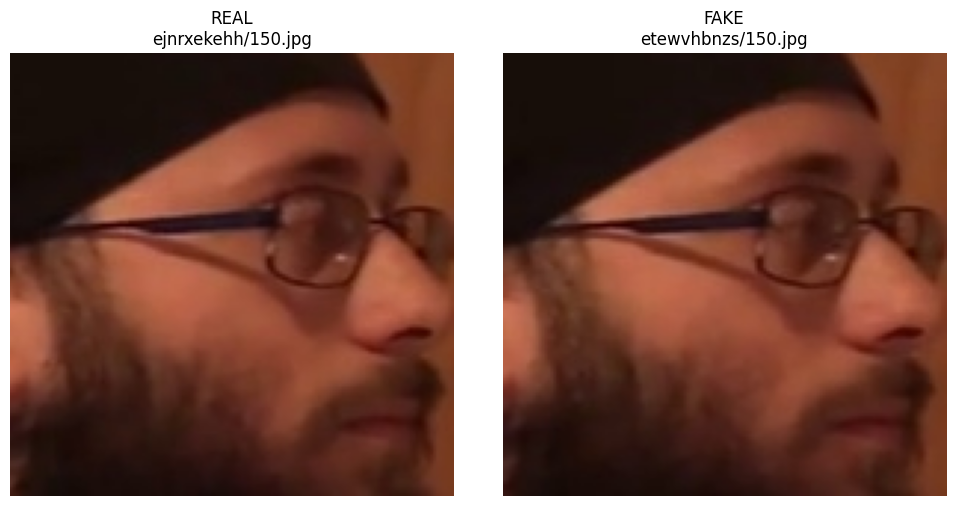

In [10]:
import matplotlib.pyplot as plt
import cv2
def show_frame_pair(base_path, real_video, real_frame, fake_video, fake_frame):
    real_path = os.path.join(base_path, "images", real_video, real_frame)
    fake_path = os.path.join(base_path, "images", fake_video, fake_frame)

    real_img = cv2.imread(real_path)
    fake_img = cv2.imread(fake_path)

    if real_img is None or fake_img is None:
        print("Görsellerden biri yüklenemedi.")
        return

    # BGR → RGB
    real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
    fake_img = cv2.cvtColor(fake_img, cv2.COLOR_BGR2RGB)

    # Görüntüle
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(real_img)
    plt.title(f"REAL\n{real_video}/{real_frame}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(fake_img)
    plt.title(f"FAKE\n{fake_video}/{fake_frame}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Örnek bir satırı seç (örneğin 5. satır)
example = paired_df.iloc[5]

show_frame_pair(
    base_path=path,
    real_video=example["real_video"],
    real_frame=example["real_frame"],
    fake_video=example["fake_video"],
    fake_frame=example["fake_frame"]
)


In [11]:
unused_fake_frames_df

,fake_video,fake_frame
0,jonyhxktri,90.jpg
1,imblbudkuk,120.jpg
2,wshnseesqc,150.jpg
3,ufomydjjvm,30.jpg
4,nlkhocvisb,270.jpg
...,...,...
19023,wijsyrvfcn,60.jpg
19024,ulemomlvpx,150.jpg
19025,rvetbtgbzi,150.jpg
19026,elrrryqpkv,210.jpg


In [12]:
paired_df

,real_video,real_frame,fake_video,fake_frame
0,ejnrxekehh,0.jpg,fkssfkbrkp,0.jpg
1,ejnrxekehh,30.jpg,zaynuhjaci,30.jpg
2,ejnrxekehh,60.jpg,awibecpxci,60.jpg
3,ejnrxekehh,90.jpg,pccwidwbwh,90.jpg
4,ejnrxekehh,120.jpg,zhmjtavtpn,120.jpg
...,...,...,...,...
3387,dawmxkceki,90.jpg,iwzxyrgxxx,90.jpg
3388,dawmxkceki,120.jpg,amswidgjne,120.jpg
3389,dawmxkceki,180.jpg,amswidgjne,180.jpg
3390,dawmxkceki,210.jpg,iwzxyrgxxx,210.jpg


In [13]:
import numpy as np
def load_image(base_path, video_folder, frame_file):
    path = os.path.join(base_path, "images", video_folder, frame_file)
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"{path} bulunamadı")
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img.astype(np.float32)
X = []
y = []

for _, row in paired_df.iterrows():
    try:
        # REAL örneği (label = 0)
        real_img = load_image(path, row['real_video'], row['real_frame'])
        X.append(real_img)
        y.append(0)

        # FAKE örneği (label = 1)
        fake_img = load_image(path, row['fake_video'], row['fake_frame'])
        X.append(fake_img)
        y.append(1)

    except Exception as e:
        print("Hata:", e)
        continue

X = np.array(X)
y = np.array(y)

print("Veri şekli:", X.shape, "Label şekli:", y.shape)

Veri şekli: (6784, 224, 224, 3) Label şekli: (6784,)


In [14]:
from sklearn.model_selection import train_test_split

# eğitim için random bölme
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.21, stratify=y, random_state=63)

In [15]:
# EfficientNet Modeli ile Transfer Learning

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = True

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[AUC(name="auc")]
)

In [16]:
# train etme
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping: val_auc yükselmiyorsa 8 epoch sonra dur
early_stop = EarlyStopping(
    monitor='val_auc',
    patience=8,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# Eğitim
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 163s 435ms/step - auc: 0.5097 - loss: 0.7172 - val_auc: 0.4357 - val_loss: 0.6981
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - auc: 0.6315 - loss: 0.6667 - val_auc: 0.5774 - val_loss: 0.6869
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - auc: 0.6932 - loss: 0.6357 - val_auc: 0.5316 - val_loss: 0.6985
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - auc: 0.7500 - loss: 0.6008 - val_auc: 0.6612 - val_loss: 0.6749
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - auc: 0.8148 - loss: 0.5505 - val_auc: 0.7268 - val_loss: 0.6210
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - auc: 0.8556 - loss: 0.5037 - val_auc: 0.6908 - val_loss: 0.6549
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - auc: 0.8865 - loss: 0.4513 - val_auc: 0.5817 - val_loss: 0.7023
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - auc: 0.9132 - loss: 0.4035 - val_auc: 0.6647 - val_loss: 0.6494
Epoch 9/100
168/168 ━━━━━━━━━━━━━━━━━

In [24]:
# evaulation
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
              precision    recall  f1-score   support

           0       0.94      0.61      0.74       713
           1       0.71      0.96      0.82       712

    accuracy                           0.78      1425
   macro avg       0.82      0.78      0.78      1425
weighted avg       0.82      0.78      0.78      1425

AUC-ROC: 0.9136048820461098
Confusion Matrix:
 [[434 279]
 [ 29 683]]


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Skorlar
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_pred_prob)

print("📊 Model Evaluation Scores")
print(f"Accuracy       : {acc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1-Score       : {f1:.4f}")
print(f"AUC-ROC        : {auc:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
📊 Model Evaluation Scores
Accuracy       : 0.7839
Precision      : 0.7100
Recall         : 0.9593
F1-Score       : 0.8160
AUC-ROC        : 0.9136
